In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load and inspect data

In [2]:
df1 = pd.read_csv("data/data-attendance-4-1.txt")
print(len(df1))
df1.head(5)

50


,PersonID,A,Score
0,1,0,69
1,2,1,145
2,3,0,125
3,4,1,86
4,5,1,158


In [3]:
df2 = pd.read_csv("data/data-attendance-4-2.txt")
print(len(df2))
df2.head(5)

2396


,PersonID,CourseID,Weather,Y
0,1,3,B,1
1,1,9,A,1
2,1,1,C,1
3,1,9,A,1
4,1,7,B,1


In [4]:
df2.nunique()

PersonID    50
CourseID    10
Weather      3
Y            2
dtype: int64

,n_class,n_attendance,p_attendance
PersonID,,,
1,43,38,0.883721
2,56,40,0.714286
3,32,24,0.750000
4,45,33,0.733333
5,33,23,0.696970


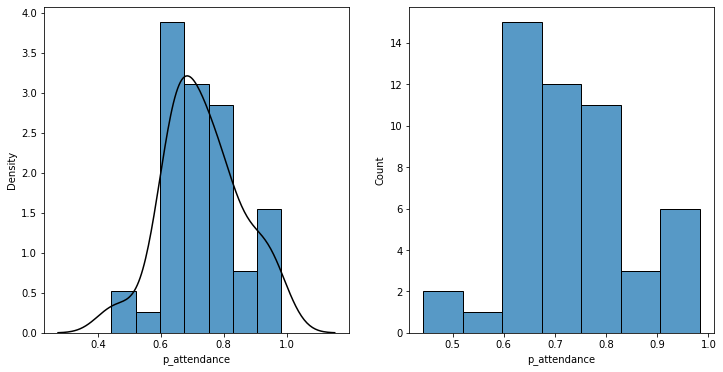

In [5]:
# exercise (4)

# Named aggregation 
# (See https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#named-aggregation )
attendance_per_student = df2.groupby("PersonID").agg(
    n_class=pd.NamedAgg(column="Y", aggfunc="count"),
    n_attendance=pd.NamedAgg(column="Y", aggfunc="sum")
)
attendance_per_student["p_attendance"] = attendance_per_student["n_attendance"] / attendance_per_student["n_class"]
display(attendance_per_student.head(5))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax = axes[0]
sns.histplot(ax=ax, stat="density", x=attendance_per_student["p_attendance"])
sns.kdeplot(ax=ax, x=attendance_per_student["p_attendance"], color='k')
ax = axes[1]
sns.histplot(ax=ax, x=attendance_per_student["p_attendance"])
fig.show()

,n_class,n_attendance,p_attendance
CourseID,,,
1,136,116,0.852941
2,364,184,0.505495
3,220,128,0.581818
4,264,245,0.928030
5,306,215,0.702614


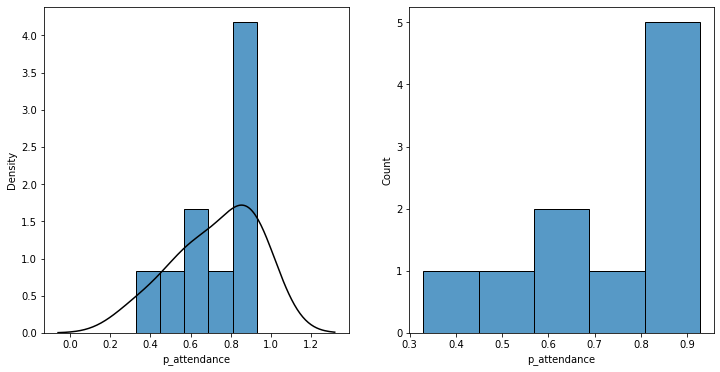

In [6]:
# exercise (5)

attendance_per_course = df2.groupby("CourseID").agg(
    n_class=pd.NamedAgg(column="Y", aggfunc="count"),
    n_attendance=pd.NamedAgg(column="Y", aggfunc="sum")
)
attendance_per_course["p_attendance"] = attendance_per_course["n_attendance"] / attendance_per_course["n_class"]
display(attendance_per_course.head(5))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax = axes[0]
sns.histplot(ax=ax, stat="density", x=attendance_per_course["p_attendance"])
sns.kdeplot(ax=ax, x=attendance_per_course["p_attendance"], color='k')
ax = axes[1]
sns.histplot(ax=ax, x=attendance_per_course["p_attendance"])
fig.show()

# Run Stan

In [7]:
model = CmdStanModel(stan_file="model/model8-8.stan")
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap08/model/model8-8


CmdStanModel: name=model8-8
	 stan_file=/workdir/chap08/model/model8-8.stan
	 exe_file=/workdir/chap08/model/model8-8
	 compiler_optons=stanc_options=None, cpp_options=None


In [8]:
def weather_to_float(weather):
    if weather == 'A':
        return 0.0
    elif weather =='B':
        return 0.2
    elif weather == 'C':
        return 1.0

In [9]:
data = {
    "N": len(df1),
    "C": int(df2.nunique().CourseID),  # without cast, "TypeError: 10 is not JSON serializable" is raised
    "I": len(df2),
    "A": df1["A"].values,
    "Score": df1["Score"].values/200,
    "PID": df2["PersonID"].values,
    "CID": df2["CourseID"].values,
    "W": np.vectorize(weather_to_float)(df2["Weather"].values),
    "Y": df2["Y"].values
}

In [10]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


In [11]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmpvi99egy9/model8-8-202010040519-1-cgz1gs5p.csv, /tmp/tmpvi99egy9/model8-8-202010040519-2-gt43junk.csv, /tmp/tmpvi99egy9/model8-8-202010040519-3-t4gk_mx7.csv, /tmp/tmpvi99egy9/model8-8-202010040519-4-43_g4y12.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /tmp/tmpvi99egy9/model8-8-202010040519-1-cgz1gs5p.csv, /tmp/tmpvi99egy9/model8-8-202010040519-2-gt43junk.csv, /tmp/tmpvi99egy9/model8-8-202010040519-3-t4gk_mx7.csv, /tmp/tmpvi99egy9/model8-8-202010040519-4-43_g4y12.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


# Plot the result

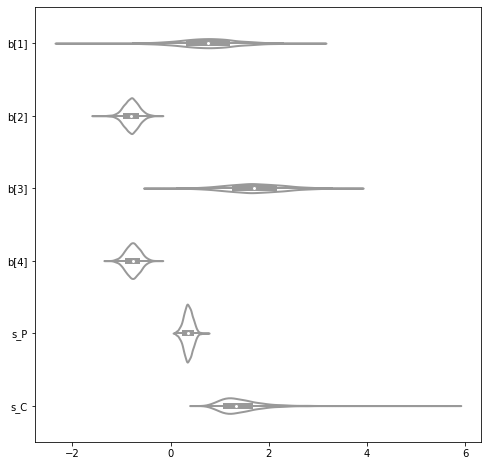

In [12]:
# Fig 8.9 left

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.violinplot(
    ax=ax, 
    data=[
        fit.stan_variable("b")[:, 0], 
        fit.stan_variable("b")[:, 1],
        fit.stan_variable("b")[:, 2],
        fit.stan_variable("b")[:, 3],
        fit.stan_variable("s_P"),
        fit.stan_variable("s_C")
    ],
    orient="h",
    color="white", linewidth=2
)
ax.set_yticklabels(["b[1]", "b[2]", "b[3]", "b[4]", "s_P", "s_C"])
fig.show()

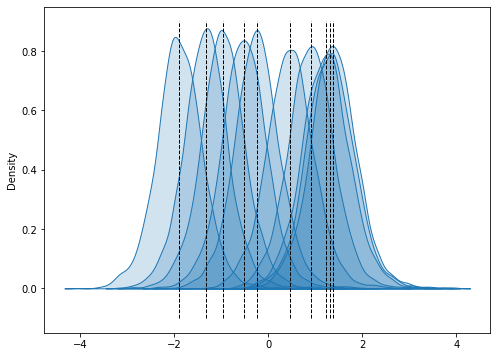

In [13]:
# Fig 8.9 right

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for c in range(10):
    samples_tmp = fit.stan_variable("b_C")[:, c]
    mean = samples_tmp.mean() # use posterior mean rather than MAP in the book
    sns.kdeplot(ax=ax, x=samples_tmp, fill=True, alpha=0.2, color="C0")
    ax.plot([mean, mean], [-0.1, 0.9], 'k--', linewidth=1)

In [14]:
q_mean = fit.stan_variable("q").mean(axis=0)
q_mean.shape

(2396,)

ROC AUC Score : 0.8016444545539139


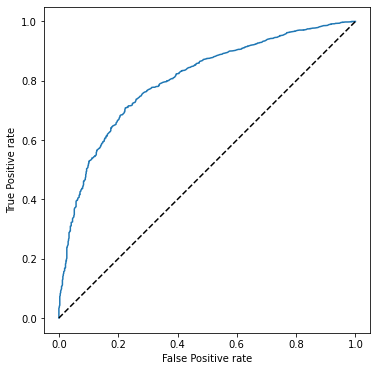

In [15]:
# ROC curve and AUC score

print("ROC AUC Score :", roc_auc_score(df2["Y"].values, q_mean))

fpr, tpr, thresholds = roc_curve(df2["Y"].values, q_mean)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], 'k--')
ax.set_aspect("equal")
ax.set_xlabel("False Positive rate")
ax.set_ylabel("True Positive rate")
plt.show()